<a href="https://colab.research.google.com/github/kb3uyi/GA-DnD-analysis/blob/main/dnd_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D&D Character Exploratory Data Analysis
### John Pruitt for GA Python class 127

## About this data set:
"This is a weekly updated dataset of character that are submitted to my web applications printSheetApp and interactiveSheet. It is a superset of the dataset I previously released under oganm/dndstats with a much larger sample (6175 characters) size and more data fields. It was inspired by the FiveThirtyEight article on race/class proportions and the data seems to correlate well with those results (see my dndstats article).

...


This data comes from characters submitted to my web applications. The applications are written to support a popular third party character sheet app for mobile platforms. I have advertised my applications primarily on Reddit r/dndnext and r/dnd. I have seen them mentioned in a few other platforms by word of mouth. That means we are looking at subsamples of subsamples here, all of which can cause some amount of selection bias. Some characters could be thought experiments or for testing purposes and never see actual game play."

  \- [oganm](https://github.com/oganm) on the project [README file](https://github.com/oganm/dnddata)


### Data dictionary (from the Github Page)

-   **ip:** A shortened hash of the IP address of the submitter

-   **finger:** A shortened hash of the browser fingerprint of the submitter

-   **name:** A shortened hash of character names

-   **race:** Race of the character as coded by the app. May be unclear as the app inconsistently codes race/subrace information. See processedRace

-   **background:** Background as it comes out of the application.

-   **date:** Time & date of input. Dates before 2018-04-16 are unreliable as some has accidentally changed while moving files around.

-   **class:** Class and level. Different classes are separated by | when needed.

-   **justClass:** Class without level. Different classes are separated by | when needed.

-   **subclass:** Subclass. Might be missing if the character is low level. Different classes are separated by | when needed.

-   **level:** Total level

-   **feats:** Feats chosen. Mutliple feats are separated by | when needed

-   **HP:** Total HP

-   **AC:** AC score

-   **Str, Dex, Con, Int, Wis, Cha:** Ability score modifiers

-   **alignment:** Alignment free text field. Since it's a free text field, it includes alignments written in many forms. See processedAlignment, good and lawful to get the standardized alignment data.

-   **skills:** List of proficient skills. Skills are separated by |.

-   **weapons:** List of weapons, separated by |. This is a free text field. See processedWeapons for the standardized version

-   **spells:** List of spells, separated by |. Each spell has its level next to it separated by \*s. This is a free text field. See processedSpells for the standardized version

-   **castingStat:** Casting stat as entered by the user. The format allows one casting stat so this is likely wrong if the character has different spellcasting classes. Also every character has a casting stat even if they are not casters due to the data format.

-   **choices:** Character building choices. This field information about character properties such as fighting styles and skills chosen for expertise. Different choice types are separated by | when needed. The choice data is written as name of choice followed by a / followed by the choices that are separated by \*s

-   **country:** The origin of the submitter's IP

-   **countryCode:** 2 letter country code

-   **processedAlignment:** Standardized version of the alignment column. I have manually matched each non standard spelling of alignment to its correct form. First character represents lawfulness (L, N, C), second one goodness (G,N,E). An empty string means alignment wasn't written or unclear.

-   **good, lawful:** Isolated columns for goodness and lawfulness

-   **processedRace:** I have gone through the way race column is filled by the app and asigned them to correct races. Also includes some common races that are not natively supported such as warforged and changelings. If empty, indiciates a homebrew race not natively supported by the app.

-   **processedSpells:** Formatting is same as spells. Standardized version of the spells column. Spells are matched to an official list using string similarity and some hardcoded rules.

-   **processedWeapons:** Formatting is same as weapons. Standardized version of the weapons column. Created like the processedSpells column.

-   **levelGroup:** Splits levels into groups. The groups represent the common ASI levels

-   **alias:** A friendly alias that correspond to each uniqe name

The list version of this dataset contains all of these fields but they are organised a little differently, keeping fields like `spells` and `processedSpells` together.

  \- [oganm](https://github.com/oganm) on the project [README file](https://github.com/oganm/dnddata)

## Step 1: Set Up Data

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Make sure to parse dates as date objects
link = "https://raw.githubusercontent.com/oganm/dnddata/master/data-raw/dnd_chars_all.tsv"
raw_dnd_frame = pd.read_csv(link, sep='\t', parse_dates=['date'])

# As I clean this data, I'll not use .dropna() across the entire data frame because some fields are intentionally blank
# Remove dates from before 2018-04-16 since the data dictionry says they are unreliable
raw_dnd_frame["date"].dtypes
cutoff_date = pd.to_datetime('2018-04-16', utc= True)
old_dates = raw_dnd_frame[raw_dnd_frame["date"] < cutoff_date]
raw_dnd_frame = raw_dnd_frame.drop(old_dates.index, axis=0)
print(f"{old_dates.shape[0]} rows removed to clean date information. \n")

# Also the names are character names, not usernames of the player. 
# and they are only hashes, so in my exploration I found some accidental hash collisions.
# Let's remove duplicates across name and justClass 
# (assuming someone with the same name and job is the same person, but increasing levels are progress for the person)
# in order to make a separate frame of semi-unique charaters.
# For some questions, what country the transactions came from, maybe you would want to include duplicates.
with_duplicate_names = raw_dnd_frame.shape[0]
unique_characters = raw_dnd_frame.sort_values(by=["date"],ascending=[True])
unique_characters.drop_duplicates(['name', 'justClass'],keep='last', inplace = True)
print(f"{raw_dnd_frame.shape[0] - unique_characters.shape[0]} fewer rows for questions with unique characters \n")

21 rows removed to clean date information. 

2313 fewer rows for questions with unique characters 



## Step 2: Explore Data

In [ ]:
#Shape of dataframe
print(f"Rows: {raw_dnd_frame.shape[0]}\nColumns: {raw_dnd_frame.shape[1]}\n")

#Columns in dataframe
print(f"Columns:\n{raw_dnd_frame.dtypes}\n")

Rows: 8590
Columns: 36

Columns:
ip                                 object
finger                             object
hash                               object
name                               object
race                               object
background                         object
date                  datetime64[ns, UTC]
class                              object
justClass                          object
subclass                           object
level                               int64
feats                              object
HP                                  int64
AC                                  int64
Str                                 int64
Dex                                 int64
Con                                 int64
Int                                 int64
Wis                                 int64
Cha                                 int64
alignment                          object
skills                             object
weapons                            object
s

## Step 2a: What are the top ten countries were users of the site from?

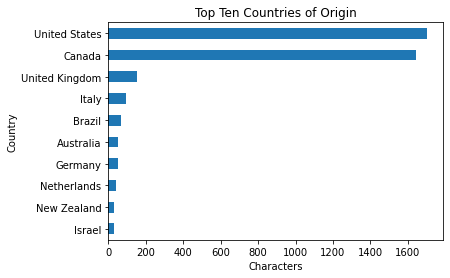

In [ ]:
country_frame = raw_dnd_frame.copy()
country_frame.sort_values(by=["country"],ascending=[False],inplace=True)
country_frame["country"].value_counts(normalize=True).iloc[0:10]

top_countries = list(country_frame["country"].value_counts(normalize=True).iloc[0:10].index.values)
top_country_subset = country_frame[country_frame["country"].isin(top_countries)]

top_country_subset.groupby(['country']).size().sort_values(ascending=True).plot.barh()
plt.title('Top Ten Countries of Origin')
plt.xlabel('Characters')
plt.ylabel('Country')
plt.show()

## Step 2b: What is the distribution of character levels?
Note: the game limits level (even for multiclassing) at 20. Above 20 is homebrew play or a joke not intended for play.

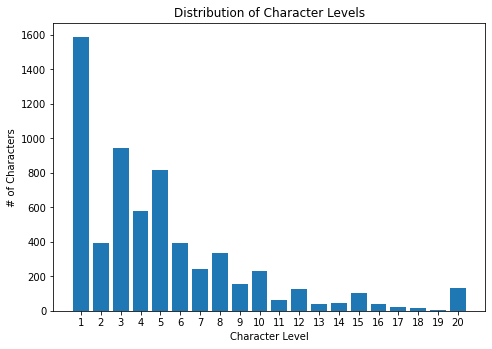

In [ ]:
level_frame = unique_characters.copy()
reasonable_levels = level_frame[level_frame['level'].isin(range(1,21))]['level']
level_distribution = reasonable_levels.value_counts().reset_index()
level_distribution.rename(columns={'index': 'Level', 'level': 'Characters'}, inplace=True)

fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.set_xticks(level_distribution['Level'])
plt.bar(level_distribution['Level'],level_distribution['Characters'])
plt.title('Distribution of Character Levels')
plt.xlabel('Character Level')
plt.ylabel('# of Characters')
plt.show()

*Wow!* Look at all those level one characters! 
Maybe they represent players who didn't like the hobby, or they could be ineffecient character designs that got replaced.

In [ ]:
level_distribution.sort_values(by=["Level"],ascending=[True],inplace=True)
level_distribution.head(2)

,Level,Characters
0,1,1589
4,2,393


## Step 2c: What is the distribution of character classes?
Note: For this data set, multiclassing is a string containing "{Class1}|{Class2}|..." so lets first see how many multiclass characters there are.

698 rows removed to make mono class set. 

5559 rows in mono class set. 



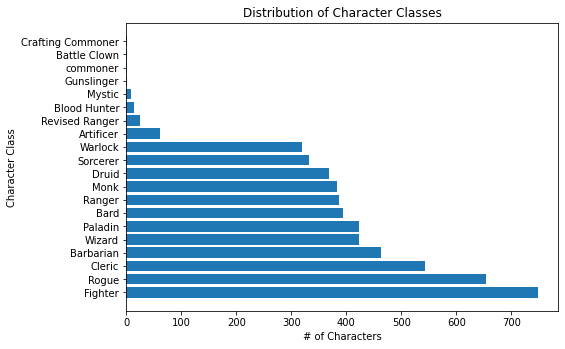

In [ ]:
# unique_characters dataframe from the intial setup
simple_chars = unique_characters.filter(items=['name', 'race','class','justClass','level', 'levelGroup','processedRace'])
simple_chars = simple_chars[simple_chars['level'].isin(range(1,21))] #remove levels not used in real play

multi_class = simple_chars[simple_chars['justClass'].str.find('|') != -1]
mono_class = simple_chars.drop(multi_class.index, axis=0)

malformed_class = simple_chars[simple_chars['justClass'].str.find('|') != -1]
mono_class = simple_chars.drop(malformed_class.index, axis=0)


def strip_newline(x):
  try: 
    return (x.strip('\n'))
  except Exception as error:
    #print(error)
    return x

mono_class['justClass'] = mono_class['justClass'].map(strip_newline, na_action = 'ignore')

print(f"{multi_class.shape[0]} rows removed to make mono class set. \n")
print(f"{mono_class.shape[0]} rows in mono class set. \n")

class_distribution = mono_class['justClass'].value_counts().reset_index()
class_distribution.rename(columns={'index': 'Class', 'justClass': 'Characters'}, inplace=True)
class_distribution.sort_values(by=['Characters'],ascending=[False],inplace=True)
class_distribution

fig = plt.figure()
ax=fig.add_axes([0,0,1,1])

plt.barh(class_distribution['Class'],class_distribution['Characters'])
plt.title('Distribution of Character Classes')
plt.xlabel('# of Characters')
plt.ylabel('Character Class')
plt.show()

I expected the class distribution to be fairly even, but the Fighter class seems to be quite a bit more popular. Multi-Classing is a somewhat advanced build, so let's see if they have higher levels (lasted longer in play).

88.84% of characters are single class, and 11.16% are multi-class.


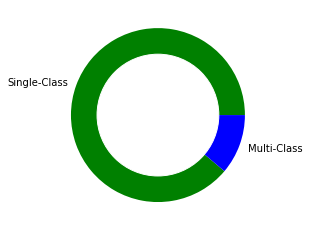

In [ ]:
# unique_characters dataframe from the intial setup
class_type = simple_chars.copy()

def single_multi(x):
  if x.find('|') != -1:
    return "Multi-Class"
  else:
    return "Single-Class"

class_type['justClass'] = class_type['justClass'].map(single_multi, na_action = 'ignore')
single_p = class_type["justClass"].value_counts(normalize=True)['Single-Class'].round(4) * 100
multi_p = class_type["justClass"].value_counts(normalize=True)['Multi-Class'].round(4) * 100
print(f"{single_p}% of characters are single class, and {multi_p}% are multi-class.")
single_multi_count = class_type['justClass'].value_counts(normalize=False).reset_index()

# Create a pie plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(single_multi_count['justClass'], labels=single_multi_count['index'], colors=['green','blue',])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


Average level for single-class is 4.49, while the average for multi-class is 8.43.


Text(0, 0.5, 'Level')

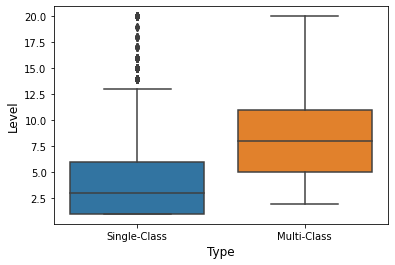

In [ ]:
# Average Level by class type
mean_level = class_type.groupby('justClass')['level'].mean().reset_index()

single_m = round(float(mean_level[mean_level["justClass"] == 'Single-Class']['level']),2)
multi_m = round(float(mean_level[mean_level["justClass"] == 'Multi-Class']['level']),2)
print(f"Average level for single-class is {single_m}, while the average for multi-class is {multi_m}.")

sns.boxplot( x=class_type["justClass"], y=class_type["level"])
plt.xlabel("Type", size=12)
plt.ylabel("Level", size=12)

This makes sense given that its more experienced and interested players that use multiclassing. Lets see how single classes compare for survivability.

Text(0, 0.5, 'Level')

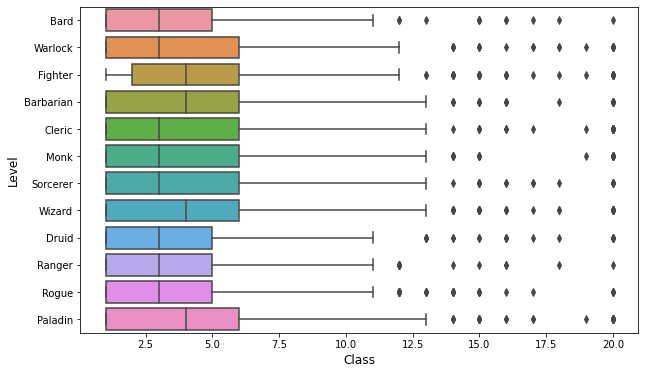

In [ ]:
# Average Level by class type
mean_level = mono_class.groupby('justClass')['level'].mean().reset_index()
mean_level

# Let's consider only classes with 100 unique characters
top_classes = mono_class["justClass"].value_counts().reset_index()
top_classes.rename(columns={'index': 'Class', 'justClass': 'Characters'}, inplace=True)
top_classes = top_classes[top_classes['Characters'] >= 100]
top_list = list(top_classes['Class'].values)
top_classes_subset = mono_class[mono_class["justClass"].isin(top_list)]

f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot( y=top_classes_subset["justClass"], x=class_type["level"])
plt.xlabel("Class", size=12)
plt.ylabel("Level", size=12)

## Step 3: Looking closer at high level play.
If the vast majority of characters are used in early levels only, lets take a subset of the high level characters to see what they look like.

## Step 3a: What Classes survive to later levels?

['1-3' '12-15' '4-7' '19-20' '8-11' '16-18']


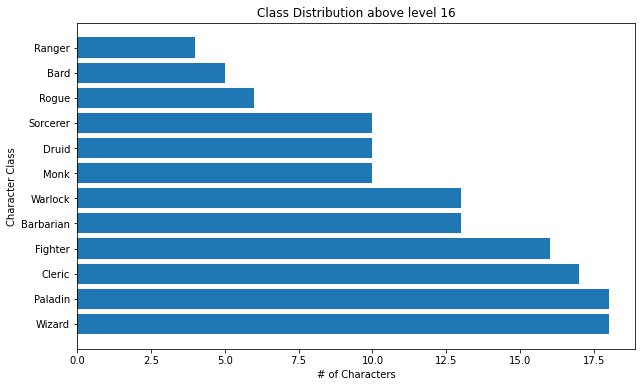

In [ ]:
print(top_classes_subset['levelGroup'].unique())
high_level_chars = top_classes_subset[top_classes_subset['levelGroup'].isin(['16-18','19-20'])]

class_count = high_level_chars['justClass'].value_counts().reset_index()
class_count.rename(columns={'index': 'Class', 'justClass': 'Characters'}, inplace=True)
class_count.sort_values(by=['Characters'],ascending=[False],inplace=True)

f, ax = plt.subplots(figsize=(10, 6))
plt.barh(class_count['Class'],class_count['Characters'])
plt.title('Class Distribution above level 16')
plt.xlabel('# of Characters')
plt.ylabel('Character Class')
plt.show()

So these are the classes that show up in high level play, indicating they are more well rounded and able to survive longer. 

Let's also show that race is less realted to character survivability. Sure, choosing one that gives you darkvision or the ability to fly or blend into the forrest has situational advantages... but over a long campaign you will have a variety of settings. 

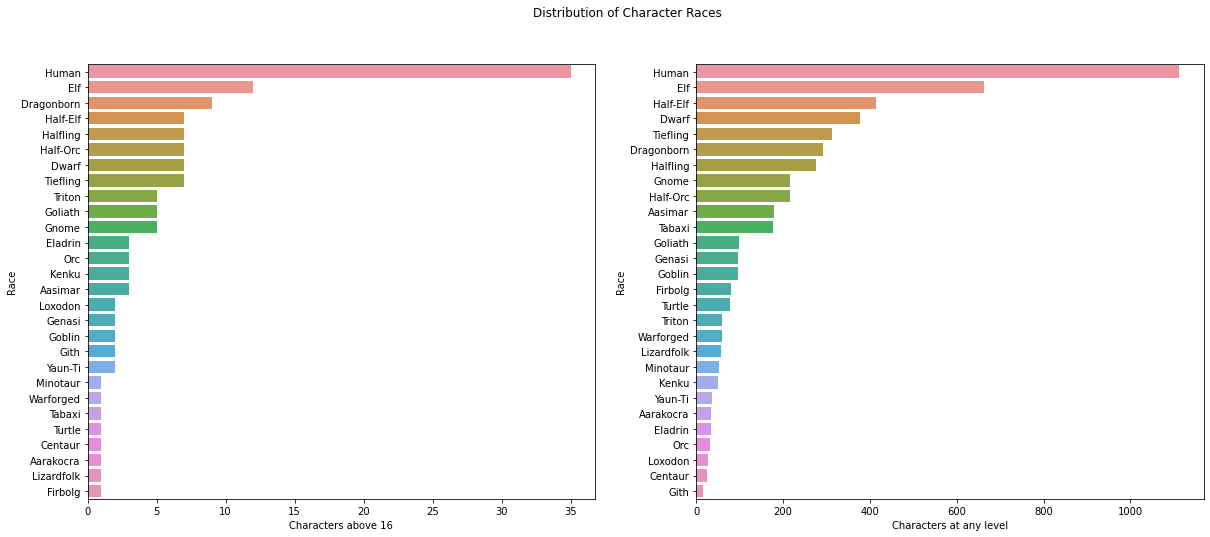

In [202]:
race_subset = high_level_chars.copy()
race_subset_all = top_classes_subset.copy()

# remove races not seen in each other's set for a better comparison. 
# by inspection, the mismatches are for very uncommon races, and we're counting the most common
race_subset_all =  race_subset_all[race_subset_all['processedRace'].isin(list(race_subset['processedRace'].unique()))] 
race_subset =  race_subset[race_subset['processedRace'].isin(list(race_subset_all['processedRace'].unique()))] 

##
## Count and graph the remaining values
##
race_count = race_subset['processedRace'].value_counts().reset_index()
race_count.rename(columns={'index': 'Race', 'processedRace': 'Characters'}, inplace=True)
race_count.sort_values(by=['Characters'],ascending=[False],inplace=True)

race_count_all = race_subset_all['processedRace'].value_counts().reset_index()
race_count_all.rename(columns={'index': 'Race', 'processedRace': 'Characters'}, inplace=True)
race_count_all.sort_values(by=['Characters'],ascending=[False],inplace=True)

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))
f.suptitle('Distribution of Character Races')
ax1 = plt.subplot(1, 2, 1)
sns.barplot(y="Race", x="Characters", data=race_count)
plt.xlabel('Characters above 16')

ax2 = plt.subplot(1, 2, 2)
sns.barplot(y="Race", x="Characters", data=race_count_all)
plt.xlabel('Characters at any level')

plt.show()

## Step 3b: Looking inside one of the most survivable classes.
If class choice is important to long play, lets consider what choices within a class are most common at high levels. 

**Note:** Every class in the game has sub-classes: choices that change their play style. Fighters have fighting styles, Wizards have schools of magic, Bards have colleges of performance, etc.

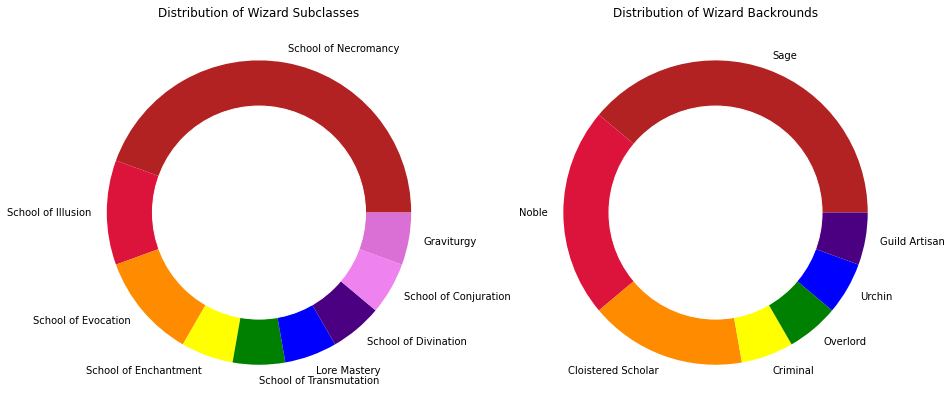

In [203]:
# class_count shows us the two most populus classes above level 16 are Wizard and Paladin
# let's make a subset of wizards in high_level_chars to see more about them.

high_council = high_level_chars[high_level_chars['justClass'] == 'Wizard']
high_council

wizard_detail = unique_characters.copy()
wizard_detail = wizard_detail[wizard_detail.index.isin(high_council.index)]

wizard_detail

# Create a pie plots
subclass_count = wizard_detail['subclass'].value_counts(normalize=False).reset_index()
subclass_count.sort_values(by=['subclass'],ascending=[False],inplace=True)
background_count = wizard_detail['background'].value_counts(normalize=False).reset_index()
background_count.sort_values(by=['background'],ascending=[False],inplace=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title('Distribution of Wizard Subclasses')
plt.pie(subclass_count['subclass'], labels=subclass_count['index'], colors=['firebrick', 'crimson', 'darkorange','yellow','green','blue', 'indigo', 'violet','orchid', 'slategrey', ])
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('Distribution of Wizard Backrounds')
plt.pie(background_count['background'], labels=background_count['index'], colors=['firebrick', 'crimson', 'darkorange','yellow','green','blue', 'indigo', 'violet','orchid', 'slategrey', ])
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

## Conclusion
We could explore more to see which subclass choices lead to survivability, but we have made some interesting conclusions so far. I heard an interview with a designer, Mike Mearls, that there are subclasses and backgrounds for each class designed to be easy to pick up, but not as deep or poweful at high levels. So my major goal in this project was to see which choices are more common for long-lived characters, demonstrating better usefulness across a broad range of situations. We found:


1.   The number of level one characters is much higher than expected, showing that many characters made see little to no play.
2.   The characters that survive to high level play have a very different class distribution than the entire set. So we can conclude that there are aspects of the class choice that improve survivability.
3.   Looking at the distribution of subclasses and backgrounds within the wizard class (one of the longest-lived classes in the dataset), we found some leaders in value count.
4.   By considering the overrepresentation of these values in the long living set, we can see that they offer better benefits for character survivability.
5. Other aspects like character race confer narrow benefits. They might increase ability scores important to a particular class' abilities, but the humans (who are generally good at all things but master of none) are massively overrepresented at low level play and high level play.




Thank you for reviewing my project.


